# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras import models
import numpy as np
from tensorflow.keras import layers, models
import keras
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import layers
import os
import seaborn as sns
from collections import Counter
from keras import backend as K
plt.style.use("ggplot")
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import glob
from pathlib import Path
import cv2
from sklearn.metrics import accuracy_score, classification_report
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from keras.applications import VGG16, InceptionV3
from keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import glob
from tensorflow.keras import layers, losses

In [2]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    print('GPU device not found. Make sure to enable GPU acceleration in the Colab notebook settings.')
else:
    print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


# Functions

In [3]:
def max_dim(images):
    max_width = 0
    max_height = 0
    for i in images:
        width, height, _ = i.shape
        max_width = max(max_width, width )
        max_height = max(max_height, height)
    return max_width, max_height

In [4]:
def evaluation(model, x_test, y_test):
    print(f"Evaluation {model.evaluate(x_test,y_test)}")
    y_pred = model.predict(x_test)
    y_pred = [i.argmax() for i in y_pred]
    print(f"Classification Report\n\n{classification_report(y_test,y_pred)}")

In [5]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    ax[0].plot(epochs, acc, 'ro', label='Training acc')
    ax[0].plot(epochs, val_acc, 'b', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'ro', label='Training loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()

In [6]:
def PCA_DENOISE(noisy_images, K):

    n_samples, height, width, channels = noisy_images.shape
    noisy_images_2d = noisy_images.reshape((n_samples, height * width * channels))
    print(height * width * channels)

    pca = PCA(n_components = K)
    denoised_images_2d = pca.fit_transform(noisy_images_2d)
    denoised_images_2d = pca.inverse_transform(denoised_images_2d)

    denoised_images = denoised_images_2d.reshape((n_samples, height, width, channels))

    return denoised_images

In [7]:
def plt_imshow(image, axis = False):
    plt.imshow(image)
    if axis == False: 
        plt.axis("off");
    plt.show

In [8]:
def gauss_noise(size, loc = 0, scale = 0.1): return np.random.normal(loc = loc, scale = scale, size = size)

# PreProcessing

In [9]:
path = "/kaggle/input/natural-images/natural_images/cat/"
images = [plt.imread(i) for i in glob.glob(path + "*")]

In [10]:
width, height = max_dim(images)
print(width, height)
images = np.array([cv2.resize(i, (width, height)) for i in images])

499 499


In [11]:
X_train, X_val = images[:200] / 255., images[200:250] / 255.

In [12]:
print(X_train.shape, X_val.shape)

(200, 499, 499, 3) (50, 499, 499, 3)


In [13]:
encoding_dim = 32
shape = (499, 499, 3)

encoder = models.Sequential([
    layers.InputLayer(input_shape=shape),
    layers.Flatten(), 
    layers.Dense(300, activation='relu'),
    layers.Dense(200, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(encoding_dim, activation='sigmoid')
])

encoder.summary()

decoder = models.Sequential([
    layers.InputLayer(input_shape=(encoding_dim,)),
    layers.Dense(100, activation='relu'),
    layers.Dense(200, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(shape[0] * shape[1] * 3, activation='sigmoid'),
    layers.Reshape(target_shape=shape) 
])

decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 747003)            0         
                                                                 
 dense (Dense)               (None, 300)               224101200 
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 32)                3232      
                                                                 
Total params: 224184732 (855.20 MB)
Trainable params: 224184732 (855.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "se

# Adding Noise To Input Images

In [14]:
X_train_noisy = X_train + gauss_noise(X_train.shape)
X_val_noisy = X_val + gauss_noise(X_val.shape)

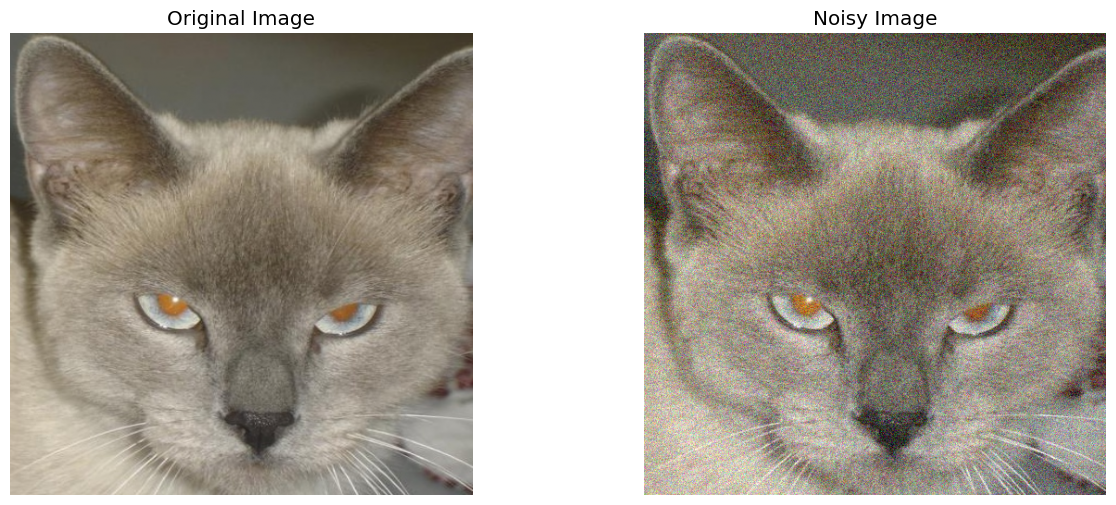

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax[0].imshow(X_train[0])
ax[0].set_title('Original Image')
ax[0].axis("off")
ax[1].imshow(X_train_noisy[0])
ax[1].set_title('Noisy Image')
ax[1].axis("off")
plt.show()

In [16]:
auto_encoder = models.Sequential([encoder, decoder])
auto_encoder.compile(optimizer='adam', loss='mse') 
history = auto_encoder.fit(X_train_noisy, X_train, epochs = 10, validation_data = (X_val_noisy,X_val))

Epoch 1/10
7/7 [==============================] - 9s 356ms/step - loss: 0.0722 - val_loss: 0.0782
Epoch 2/10
7/7 [==============================] - 1s 170ms/step - loss: 0.0720 - val_loss: 0.0778
Epoch 3/10
7/7 [==============================] - 1s 174ms/step - loss: 0.0710 - val_loss: 0.0762
Epoch 4/10
7/7 [==============================] - 1s 178ms/step - loss: 0.0674 - val_loss: 0.0746
Epoch 5/10
7/7 [==============================] - 1s 169ms/step - loss: 0.0649 - val_loss: 0.0764
Epoch 6/10
7/7 [==============================] - 1s 175ms/step - loss: 0.0650 - val_loss: 0.0743
Epoch 7/10
7/7 [==============================] - 1s 172ms/step - loss: 0.0647 - val_loss: 0.0744
Epoch 8/10
7/7 [==============================] - 1s 173ms/step - loss: 0.0644 - val_loss: 0.0749
Epoch 9/10
7/7 [==============================] - 1s 172ms/step - loss: 0.0646 - val_loss: 0.0746
Epoch 10/10
7/7 [==============================] - 1s 168ms/step - loss: 0.0645 - val_loss: 0.0745


In [17]:
encoded_data = encoder.predict(X_val_noisy) 
decoded_data = decoder.predict(encoded_data)

2/2 [==============================] - 0s 7ms/step


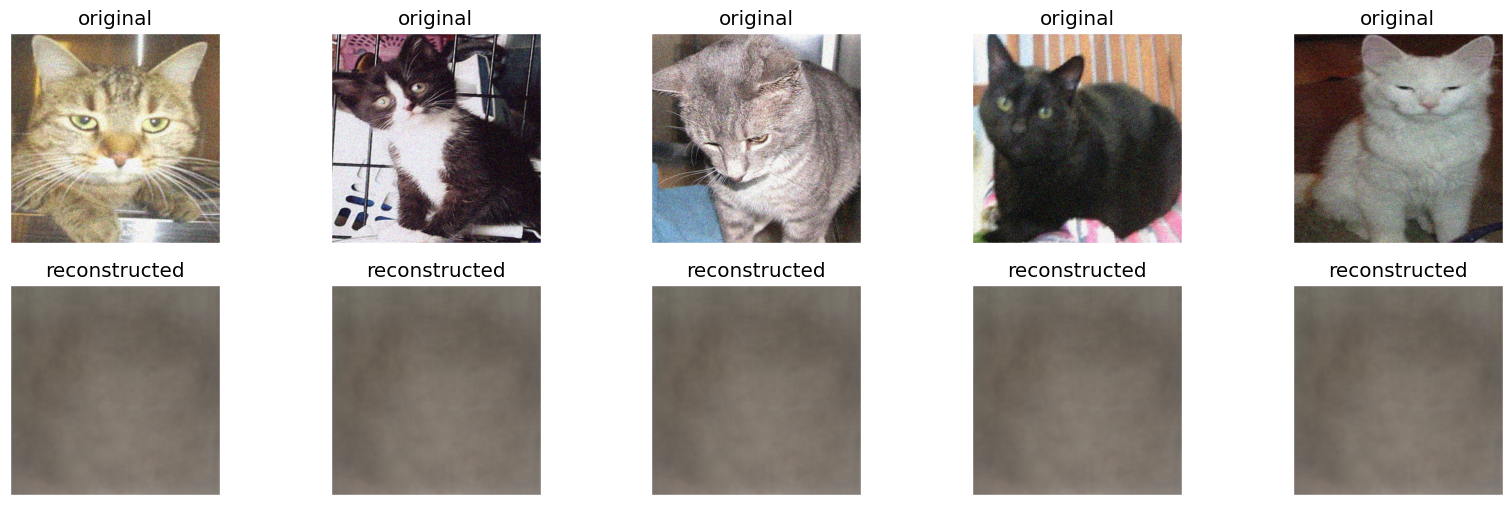

In [18]:
n = 5
plt.figure(figsize=(20, 6))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
    
  plt.imshow(X_val_noisy[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_data[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Adding Noise to Code

In [19]:
auto_encoder = models.Sequential([encoder, decoder])
auto_encoder.compile(optimizer='adam', loss='mse') 
history = auto_encoder.fit(X_train, X_train, epochs = 10, validation_data = (X_val, X_val))

Epoch 1/10
7/7 [==============================] - 5s 351ms/step - loss: 0.0646 - val_loss: 0.0744
Epoch 2/10
7/7 [==============================] - 1s 171ms/step - loss: 0.0645 - val_loss: 0.0744
Epoch 3/10
7/7 [==============================] - 1s 172ms/step - loss: 0.0645 - val_loss: 0.0749
Epoch 4/10
7/7 [==============================] - 1s 172ms/step - loss: 0.0645 - val_loss: 0.0750
Epoch 5/10
7/7 [==============================] - 1s 171ms/step - loss: 0.0647 - val_loss: 0.0750
Epoch 6/10
7/7 [==============================] - 1s 173ms/step - loss: 0.0645 - val_loss: 0.0742
Epoch 7/10
7/7 [==============================] - 1s 179ms/step - loss: 0.0648 - val_loss: 0.0746
Epoch 8/10
7/7 [==============================] - 1s 176ms/step - loss: 0.0645 - val_loss: 0.0752
Epoch 9/10
7/7 [==============================] - 1s 170ms/step - loss: 0.0647 - val_loss: 0.0750
Epoch 10/10
7/7 [==============================] - 1s 169ms/step - loss: 0.0646 - val_loss: 0.0741


In [20]:
encoded_data = encoder.predict(X_val) 
decoded_data = decoder.predict(encoded_data + gauss_noise(encoded_data.shape))

2/2 [==============================] - 0s 7ms/step


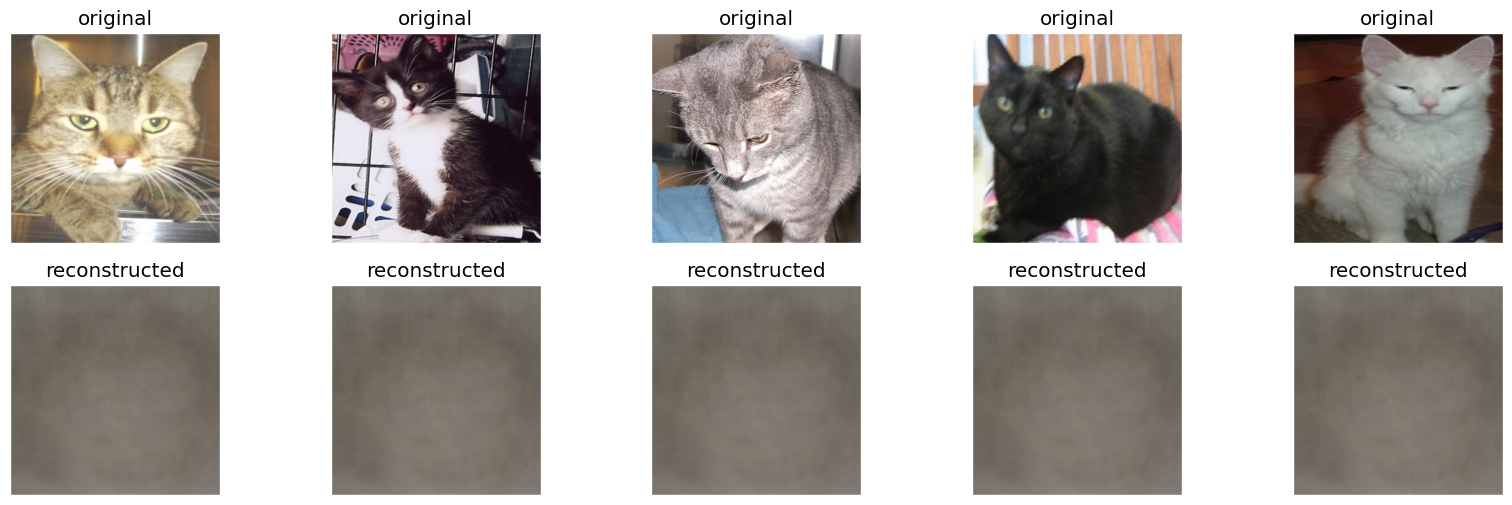

In [21]:
n = 5
plt.figure(figsize=(20, 6))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
    
  plt.imshow(X_val[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_data[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Using Conv Layers

In [22]:
shape = (499+13, 499+13, 3) # For calculation convenience
X_train = np.array([cv2.resize(i, (shape[0], shape[1])) for i in X_train])
X_val = np.array([cv2.resize(i, (shape[0], shape[1])) for i in X_val])

In [23]:
X_train_noisy = X_train + gauss_noise(X_train.shape)
X_val_noisy = X_val + gauss_noise(X_val.shape)

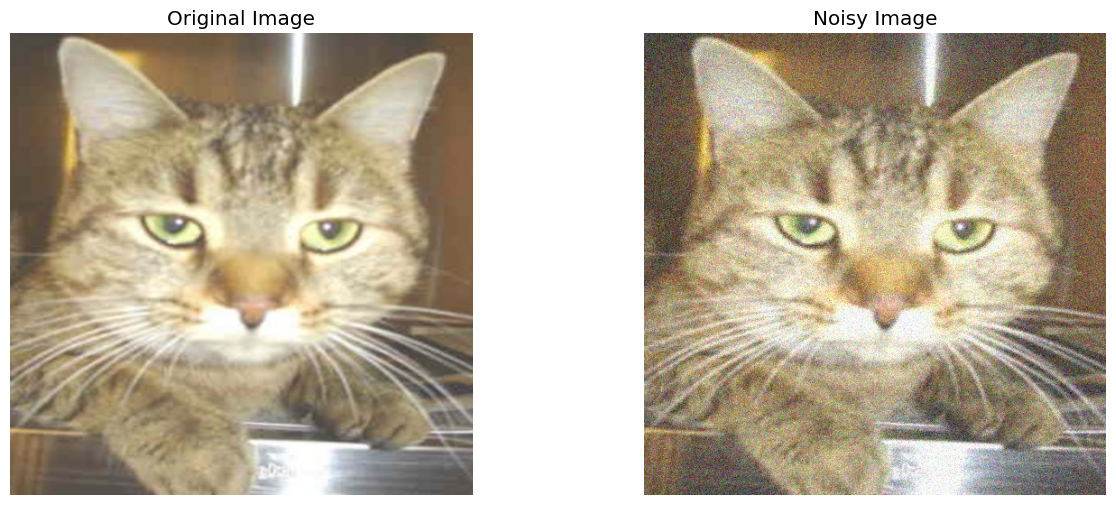

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax[0].imshow(X_val[0])
ax[0].set_title('Original Image')
ax[0].axis("off")
ax[1].imshow(X_val_noisy[0])
ax[1].set_title('Noisy Image')
ax[1].axis("off")
plt.show()

In [25]:
conv_autoencoder = models.Sequential([
    # Encoder
    layers.Conv2D(input_shape=shape,filters = 6, kernel_size=(3,3),activation='relu',padding='same'),
    layers.MaxPooling2D(padding = "same"),
    layers.Conv2D(filters = 12, kernel_size=(3,3),activation='relu',padding='same'),
    layers.MaxPooling2D(padding = "same"),
    layers.Conv2D(filters = 18, kernel_size=(5,5),activation='relu',padding='same'),
    layers.MaxPooling2D(padding = "same"),
    layers.Conv2D(filters = 24, kernel_size=(7,7),activation='relu',padding='same'),
    layers.MaxPooling2D(padding = "same"),
    # Decoder
    layers.UpSampling2D(),
    layers.Conv2D(filters = 24, kernel_size=(7,7),activation='relu',padding='same'),
    layers.UpSampling2D(),
    layers.Conv2D(filters = 18, kernel_size=(5,5),activation='relu',padding='same'),
    layers.UpSampling2D(),
    layers.Conv2D(filters = 12, kernel_size=(3,3),activation='relu',padding='same'),
    layers.UpSampling2D(),
    layers.Conv2D(filters = 6, kernel_size=(3,3),activation='relu',padding='same'),
    layers.Conv2D(filters = 3, kernel_size=(3,3),activation='sigmoid',padding='same'), 
])

conv_autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 6)       168       
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 256, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 12)      660       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 128, 128, 12)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 18)      5418      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 18)       

In [26]:
conv_autoencoder.compile(optimizer='adam', loss = 'mse')

In [27]:
history = conv_autoencoder.fit(x= X_train_noisy,y = X_train, epochs = 10, validation_data = (X_val_noisy, X_val))

Epoch 1/10
7/7 [==============================] - 19s 991ms/step - loss: 0.0691 - val_loss: 0.0684
Epoch 2/10
7/7 [==============================] - 2s 301ms/step - loss: 0.0542 - val_loss: 0.0441
Epoch 3/10
7/7 [==============================] - 2s 301ms/step - loss: 0.0364 - val_loss: 0.0377
Epoch 4/10
7/7 [==============================] - 2s 311ms/step - loss: 0.0332 - val_loss: 0.0312
Epoch 5/10
7/7 [==============================] - 2s 300ms/step - loss: 0.0250 - val_loss: 0.0193
Epoch 6/10
7/7 [==============================] - 2s 307ms/step - loss: 0.0189 - val_loss: 0.0176
Epoch 7/10
7/7 [==============================] - 2s 309ms/step - loss: 0.0151 - val_loss: 0.0126
Epoch 8/10
7/7 [==============================] - 2s 313ms/step - loss: 0.0129 - val_loss: 0.0119
Epoch 9/10
7/7 [==============================] - 2s 306ms/step - loss: 0.0114 - val_loss: 0.0104
Epoch 10/10
7/7 [==============================] - 2s 305ms/step - loss: 0.0104 - val_loss: 0.0099


In [28]:
decoded_data = conv_autoencoder.predict(X_val_noisy) 

2/2 [==============================] - 0s 73ms/step


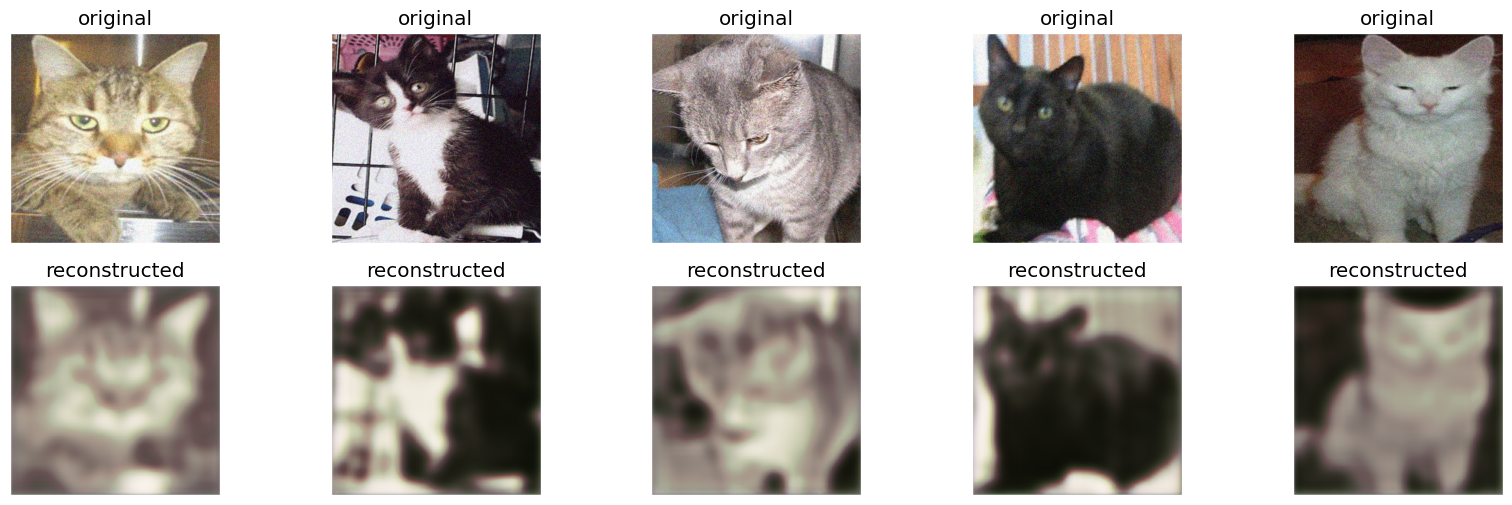

In [29]:
n = 5
plt.figure(figsize=(20, 6))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
    
  plt.imshow(X_val_noisy[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_data[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Denoise Using PCA

In [30]:
X_train_noisy = X_train + gauss_noise(X_train.shape)

786432


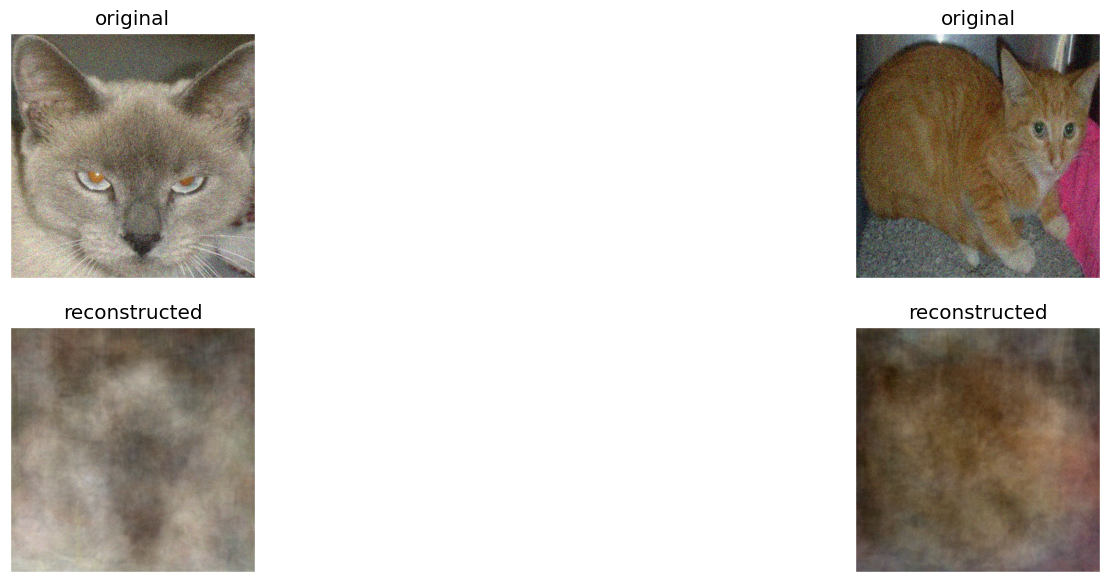

In [31]:
pca_images = PCA_DENOISE(X_train_noisy, 50)
n = 2
plt.figure(figsize=(20, 7))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
    
  plt.imshow(X_train_noisy[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(pca_images[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

786432


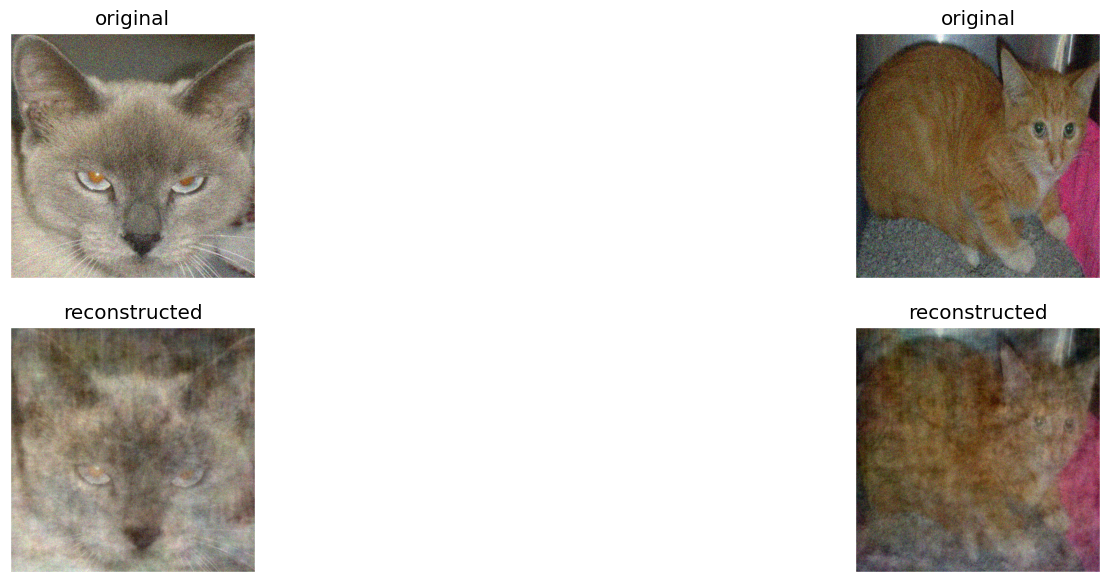

In [32]:
pca_images = PCA_DENOISE(X_train_noisy, 150)
n = 2
plt.figure(figsize=(20, 7))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
    
  plt.imshow(X_train_noisy[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(pca_images[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

786432


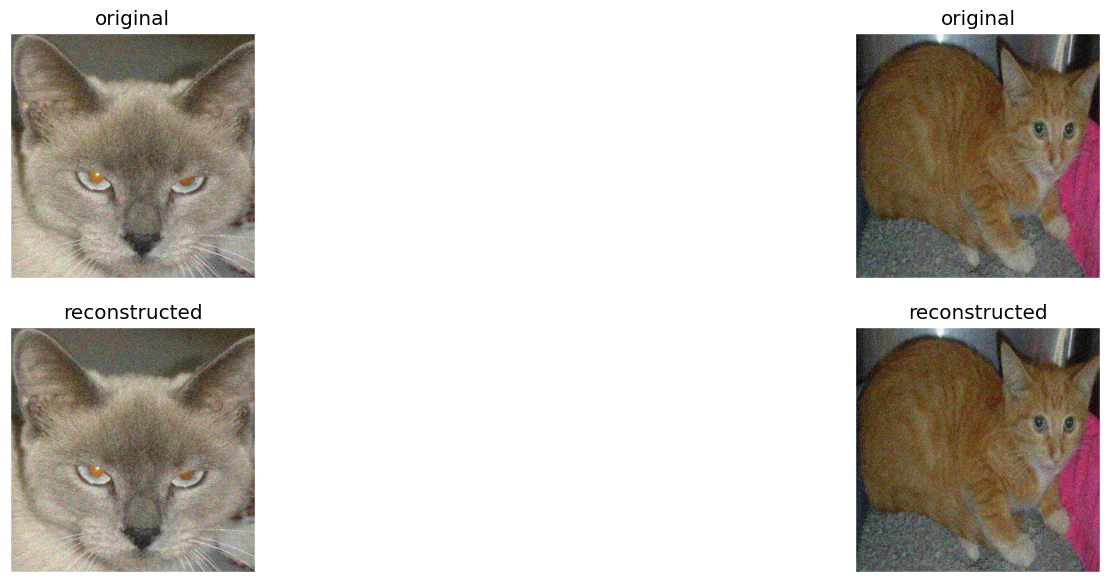

In [33]:
pca_images = PCA_DENOISE(X_train_noisy, 200)
n = 2
plt.figure(figsize=(20, 7))
for i in range(n):
  ax = plt.subplot(2, n, i + 1)
    
  plt.imshow(X_train_noisy[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(pca_images[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()